**Mongolia Rangelands regression**

**Prelim data exploration results so far:**
* subset_predictors1 = ['NDVI_mean', TNC ecosyst types, 'wcs_eco','EFT-1','EFT-2','EFT-3']
    * lm r2= .3-.41 
    * xgb r2=.39-45
* subset_predictors3 = ['NDVI_mean', 'wcs_eco','EFT-1','EFT-2','EFT-3', 'Kmeans_g', 'Kmeans_10y']
    * lm r2= .3-.47(!)
    * xgb same range.
* subset_predictors = all NDVIs
    * lm r2= .35-.45(!)    

    
--> r2 results HIGHLY dependant on train/test split --> Not enough data??


Much more dependant on that, then on the choice of inputs features :'( 
    


**What to do with little data**
* Avoid complex models (too many itneractions will overfit for sure)
* Stats problem more than ML **(re-READ ESL !!)**
* Clean data af. (outliers)


* Bayesian Modeling and Model Averaging
* Return conf intervals

--> TODO: HOLDOUT SET (post cleaning outliers.)

Bottomline: need to refresh my stats knowledge

#### Prelim results of interest

In [417]:
print('Coeff importance in simple linear reg\n')
for i in np.arange(0,len(X_train.columns),1):
    print(X_train.columns[i]+' : %.1f '%(abs(regr.coef_[i])/sum(abs(regr.coef_))*100)+'%')

Coeff importance in simple linear reg

NDVI_mean : 81.6 %
EFT-1 : 0.3 %
EFT-2 : 0.1 %
EFT-3 : 0.1 %
TNC_ecosyst_12 : 0.1 %
TNC_ecosyst_13 : 0.9 %
TNC_ecosyst_30 : 0.7 %
TNC_ecosyst_40 : 1.0 %
TNC_ecosyst_50 : 0.7 %
TNC_ecosyst_51 : 0.2 %
TNC_ecosyst_52 : 0.2 %
TNC_ecosyst_60 : 0.7 %
TNC_ecosyst_88 : 0.8 %
TNC_ecosyst_91 : 0.0 %
TNC_ecosyst_92 : 1.5 %
TNC_ecosyst_94 : 5.6 %
TNC_ecosyst_95 : 1.9 %
wcs_eco_desert_steppe : 1.2 %
wcs_eco_semi_desert : 1.6 %
wcs_eco_true_desert : 0.8 %


# Imports

In [381]:
import csv
import os 
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [146]:
df = pd.read_excel('../Data/all_data_all_years.xlsx')

In [150]:
df 

,year,site_id,Rangeland metric score,Cover of all vegetation,NDVI_min,NDVI_max,NDVI_area,NDVI_range,NDVI_mean,TNC_ecosystem_types,...,Cover.of.Haloxylon,Cover.of.all.perennial.grasses.and.sedges,Cover.of.all.annual.grasses.and.sedges,Cover.of.all.perennial.forbs,Cover.of.all.annual.forbs,Cover.of.litter,Species.richness.of.all.shrubs,Species.richness.of.all.grasses.and.sedges,Species.richness.of.all.forbs,Max.height.of.roots.exposed.by.soil.loss
0,2016,oldst08,58.289528,32.500000,0.0943,0.1313,13.0175,0.0370,0.10670,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,oldst09,14.366699,7.500000,0.0673,0.0873,8.9843,0.0200,0.07364,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,oldst10,61.212342,32.000000,0.0884,0.1321,12.4660,0.0437,0.10218,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,oldst11,35.978836,30.000000,0.0893,0.1344,12.7173,0.0451,0.10424,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,oldst32,61.212342,32.000000,0.0850,0.1227,11.8174,0.0377,0.09686,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,2018,V73,43.784143,39.866833,0.0963,0.1563,13.3474,0.0600,0.10941,30,...,0.0,0.000000,34.332085,0.041615,0.083229,0.0,2.0,2.0,6.0,0.0
408,2018,V74,52.739985,32.584270,0.0928,0.2597,15.4817,0.1669,0.12690,91,...,0.0,9.176030,9.363296,11.444028,2.580108,0.0,1.0,3.0,11.0,0.0
409,2018,V75,63.054054,55.152274,0.0852,0.2629,14.1915,0.1777,0.11632,40,...,0.0,20.650814,0.208594,4.860242,28.598248,0.0,2.0,3.0,10.0,0.0
410,2018,V76,45.849447,14.464100,0.1010,0.1374,13.3708,0.0364,0.10960,30,...,0.0,0.228928,0.228928,0.041623,2.934443,0.0,6.0,4.0,7.0,0.0


# Pre-processing

In [501]:
df = pd.read_excel('../Data/all_data_all_years.xlsx')
df.columns

Index(['year', 'site_id', 'Rangeland metric score', 'Cover of all vegetation',
       'NDVI_min', 'NDVI_max', 'NDVI_area', 'NDVI_range', 'NDVI_mean',
       'TNC_ecosystem_types', 'wcs_eco', 'Mongolia_Full_cluster',
       'Kmeans_cluster', 'EFT111-533', 'BrownTime', 'GreenTime', 'Mean',
       'MMax', 'SD', 'Cover.of.all.shrubs', 'Cover.of.all.succulent.shrubs',
       'Cover.of.all.Fabaceous.shrubs', 'Cover.of.all.Artemisia.species',
       'Cover.of.Haloxylon', 'Cover.of.all.perennial.grasses.and.sedges',
       'Cover.of.all.annual.grasses.and.sedges',
       'Cover.of.all.perennial.forbs', 'Cover.of.all.annual.forbs',
       'Cover.of.litter', 'Species.richness.of.all.shrubs',
       'Species.richness.of.all.grasses.and.sedges',
       'Species.richness.of.all.forbs',
       'Max.height.of.roots.exposed.by.soil.loss'],
      dtype='object')

In [503]:
df['wcs_eco'].value_counts()

semi_desert      198
true_desert       93
desert_steppe     71
Name: wcs_eco, dtype: int64

## Kmeans cluster regroup in fewer categories
Kmeans: huge class imbalance


In [275]:
df['Kmeans_cluster'].value_counts()

15    167
7      67
10     46
3      26
12     22
13     18
17     17
8       9
16      8
9       7
6       7
1       7
0       7
18      2
19      1
14      1
Name: Kmeans_cluster, dtype: int64

In [274]:
# Same in % 
round(df['Kmeans_cluster'].value_counts()/len(df['Kmeans_cluster'])*100,0)

15    41.0
7     16.0
10    11.0
3      6.0
12     5.0
13     4.0
17     4.0
8      2.0
16     2.0
9      2.0
6      2.0
1      2.0
0      2.0
18     0.0
19     0.0
14     0.0
Name: Kmeans_cluster, dtype: float64

In [285]:
def Kmeans_5y_trajectory_reclass(x):
    if x==0 or x==8 or x==9 or x==10:
        return 'Increase'
    elif x==1 or x==7 or x==13:
        return 'Steep Increase'
    elif x==11:
        return 'Gradual Increase'
    elif x==12:
        return 'Steep Decrease'
    elif x>=16:
        return 'Stasis'
    elif x==4 or x==15:
        return 'Spike'
    elif x==5 or x==14:
        return 'Decrease'
    else:
        return 'Noise'

In [287]:
df['Kmeans_cluster_5y'] = df['Kmeans_cluster'].apply(lambda x:Kmeans_5y_trajectory_reclass(x))
df['Kmeans_cluster_5y'].value_counts()

Spike             167
Steep Increase     92
Increase           69
Noise              33
Stasis             28
Steep Decrease     22
Decrease            1
Name: Kmeans_cluster_5y, dtype: int64

In [430]:
def Kmeans_10y_trajectory_reclass(x):
    if x==0 or x==8 or x==9 or x==10:
        return 'Increase'
    elif x==1 or x==7 or x==13:
        return 'Steep Increase'
    elif x==12:
        return 'Steep Decrease'
    elif x==11 or x>=16:
        return 'Stasis'
    elif x==4 or x==5 or x==12 or x==14 or x==15:
        return 'Spike/Decrease'
    else:
        return 'Noise'
    
df['Kmeans_cluster_10y'] = df['Kmeans_cluster'].apply(lambda x:Kmeans_10y_trajectory_reclass(x))
df['Kmeans_cluster_10y'].value_counts()


Spike/Decrease    168
Steep Increase     92
Increase           69
Noise              33
Stasis             28
Steep Decrease     22
Name: Kmeans_cluster_10y, dtype: int64

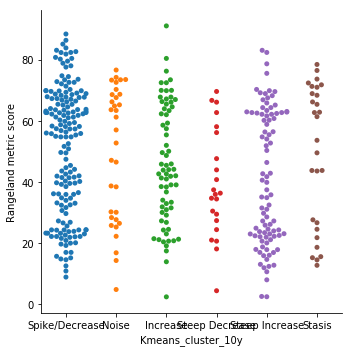

In [301]:
sns.catplot(x="Kmeans_cluster_10y", y="Rangeland metric score", kind="swarm", data=df);

In [431]:
def Kmeans_graph_reclass(x):
    if x==0 or x==1 or (x>=7 and x<=10) or x==13:
        return 'Up'
    elif x<=6 or x==12 or x==14 or x==15:
        return 'Spike'
    elif x==11 or x>=16:
        return 'Up-ish'
    else:
        return 'Failed reclass'
    
df['Kmeans_cluster_g'] = df['Kmeans_cluster'].apply(lambda x:Kmeans_graph_reclass(x))
df['Kmeans_cluster_g'].value_counts()

Spike     223
Up        161
Up-ish     28
Name: Kmeans_cluster_g, dtype: int64

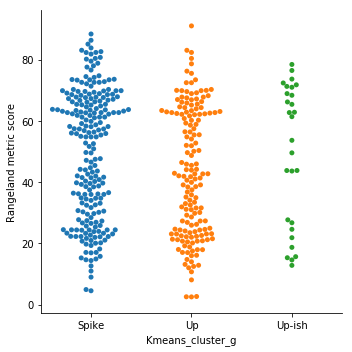

In [324]:
sns.catplot(x="Kmeans_cluster_g", y="Rangeland metric score", kind="swarm", data=df);

## Split EFT111-533 into 3 cols
    (then it's ordinal)

In [465]:
df['EFT-1']= df['EFT111-533'].apply(lambda a:int(str(a)[0]))
df['EFT-2']= df['EFT111-533'].apply(lambda a:int(str(a)[1]))
df['EFT-3']= df['EFT111-533'].apply(lambda a:int(str(a)[2]))

df[['EFT111-533','EFT-1','EFT-2','EFT-3']].head()

,EFT111-533,EFT-1,EFT-2,EFT-3
0,332,3,3,2
1,232,2,3,2
2,232,2,3,2
3,232,2,3,2
4,332,3,3,2


## Subset predictors of interest

In [436]:
df.columns

Index(['Rangeland metric score', 'NDVI_mean', 'Kmeans_cluster_10y',
       'Kmeans_cluster_g', 'wcs_eco', 'EFT-1', 'EFT-2', 'EFT-3'],
      dtype='object')

In [ ]:
subset_predictors1 = ['NDVI_mean', 'TNC_ecosystem_types', 'wcs_eco','EFT-1','EFT-2','EFT-3']

df = df[['Rangeland metric score']+subset_predictors1]

In [466]:
subset_predictors2 = ['NDVI_mean', 'wcs_eco','EFT-1','EFT-2','EFT-3']

df = df[['Rangeland metric score']+subset_predictors2]

In [434]:
subset_predictors3 = ['NDVI_mean', 'Kmeans_cluster_10y','Kmeans_cluster_g','wcs_eco','EFT-1','EFT-2','EFT-3']
df = df[['Rangeland metric score']+subset_predictors3]

In [475]:
ndvi_subset_predictors = ['NDVI_mean', 'NDVI_min','NDVI_max','NDVI_range']
df = df[['Rangeland metric score']+ndvi_subset_predictors]

In [ ]:
// Then  reaplce 'EFTs' by  'BrownTime', 'GreenTime', 'Mean','SD'
variables_for_Rangelands_score = ['Cover of all vegetation',
                                  'Cover.of.all.shrubs', 'Cover.of.all.succulent.shrubs',
       'Cover.of.all.Fabaceous.shrubs', 'Cover.of.all.Artemisia.species',
       'Cover.of.Haloxylon', 'Cover.of.all.perennial.grasses.and.sedges',
       'Cover.of.all.annual.grasses.and.sedges',
       'Cover.of.all.perennial.forbs', 'Cover.of.all.annual.forbs',
       'Cover.of.litter', 'Species.richness.of.all.shrubs',
       'Species.richness.of.all.grasses.and.sedges',
       'Species.richness.of.all.forbs',
       'Max.height.of.roots.exposed.by.soil.loss']

## Get dummies of Categorical (non-Ordinal) variables.

Ecoregions
* 'TNC_ecosystem_types': 13 distinct categorical values.
* 'wcs_eco' : 3 categories (strings)

In [90]:
dfD = pd.concat([df.drop('TNC_ecosystem_types', axis=1), pd.get_dummies(df['TNC_ecosystem_types'],prefix='TNC_ecosyst')], axis=1)

In [467]:
dfD = pd.concat([df.drop('wcs_eco', axis=1), pd.get_dummies(df['wcs_eco'],prefix='wcs_eco')], axis=1)

In [448]:
dfD = pd.concat([dfD.drop('Kmeans_cluster_g', axis=1), pd.get_dummies(dfD['Kmeans_cluster_g'],prefix='Kmeans_g')], axis=1)

In [450]:
dfD = pd.concat([dfD.drop('Kmeans_cluster_10y', axis=1), pd.get_dummies(dfD['Kmeans_cluster_10y'],prefix='Kmeans_10y')], axis=1)

# Distribution of metrics

## Plot distribution for each metric

In [18]:
for var in possible_predictors+['Rangeland metric score']:
    print(var)
    

NDVI_min
NDVI_max
NDVI_area
NDVI_range
NDVI_mean
TNC_ecosystem_types
wcs_eco
Mongolia_Full_cluster
Kmeans_cluster
EFT111-533
BrownTime
GreenTime
Mean
SD
Rangeland metric score


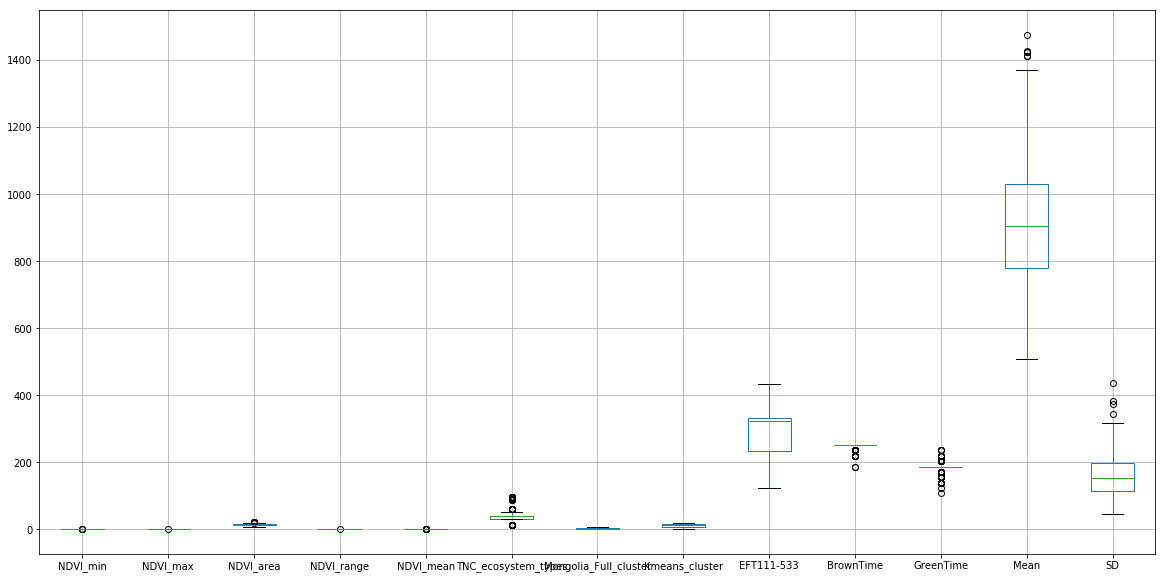

In [16]:
fig, ax = plt.subplots(figsize=(20,10))    

df[possible_predictors].boxplot(ax=ax)

In [92]:
df.describe()

,Rangeland metric score,NDVI_mean,TNC_ecosystem_types,EFT-1,EFT-2,EFT-3
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,46.918257,0.106724,39.385922,2.640777,2.648058,2.014563
std,21.102696,0.021359,15.580857,0.910649,0.583572,0.269778
min,2.494331,0.054870,12.000000,1.000000,2.000000,1.000000
25%,26.696757,0.092485,30.000000,2.000000,2.000000,2.000000
50%,47.545415,0.106010,40.000000,3.000000,3.000000,2.000000
75%,65.269511,0.119380,40.000000,3.000000,3.000000,2.000000
max,91.007991,0.182740,95.000000,4.000000,4.000000,3.000000


/Users/charlotteweil1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


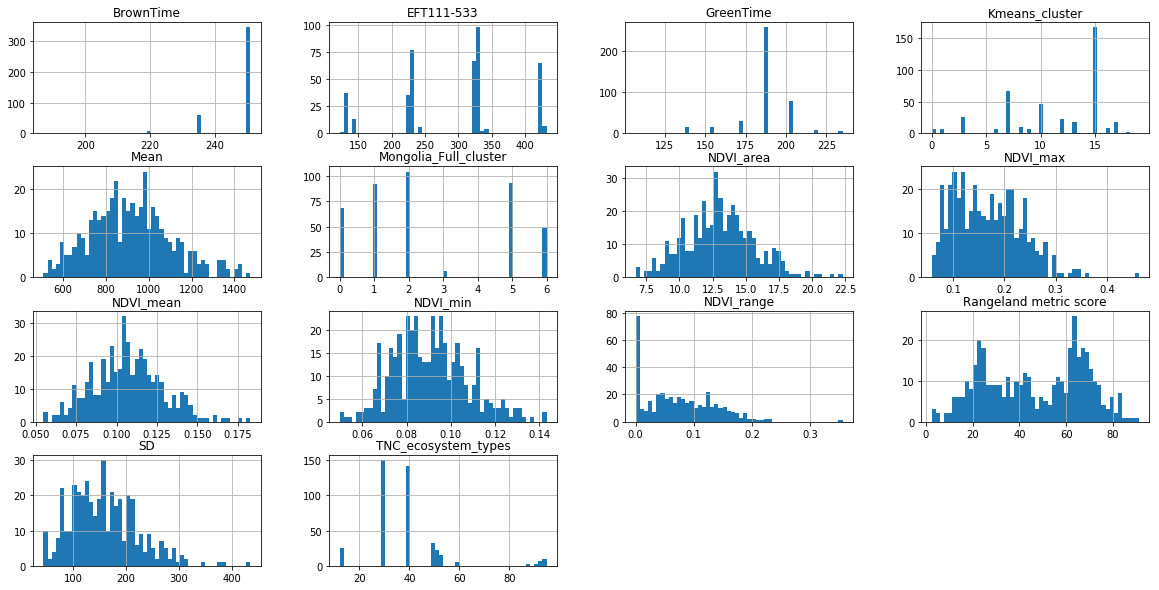

In [24]:
fig, ax = plt.subplots(figsize=(20,10))    
df[possible_predictors+['Rangeland metric score']].hist(bins=50,ax=ax);

/Users/charlotteweil1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


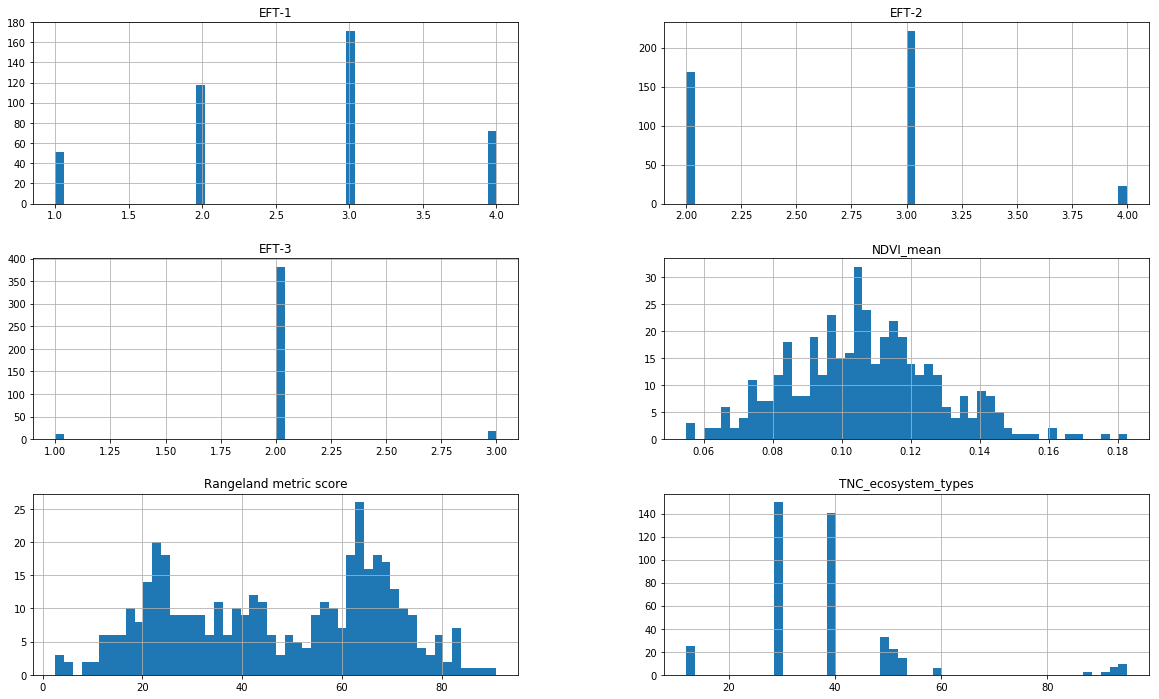

In [93]:
fig, ax = plt.subplots(figsize=(20,12))    
df.hist(bins=50,ax=ax);

## Hunt outliers

There's not enough data?

In [327]:
df.columns

Index(['year', 'site_id', 'Rangeland metric score', 'Cover of all vegetation',
       'NDVI_min', 'NDVI_max', 'NDVI_area', 'NDVI_range', 'NDVI_mean',
       'TNC_ecosystem_types', 'wcs_eco', 'Mongolia_Full_cluster',
       'Kmeans_cluster', 'EFT111-533', 'BrownTime', 'GreenTime', 'Mean',
       'MMax', 'SD', 'Cover.of.all.shrubs', 'Cover.of.all.succulent.shrubs',
       'Cover.of.all.Fabaceous.shrubs', 'Cover.of.all.Artemisia.species',
       'Cover.of.Haloxylon', 'Cover.of.all.perennial.grasses.and.sedges',
       'Cover.of.all.annual.grasses.and.sedges',
       'Cover.of.all.perennial.forbs', 'Cover.of.all.annual.forbs',
       'Cover.of.litter', 'Species.richness.of.all.shrubs',
       'Species.richness.of.all.grasses.and.sedges',
       'Species.richness.of.all.forbs',
       'Max.height.of.roots.exposed.by.soil.loss', 'Kmeans_cluster_5y',
       'Kmeans_cluster_10y', 'Kmeans_cluster_g'],
      dtype='object')

### NDVI

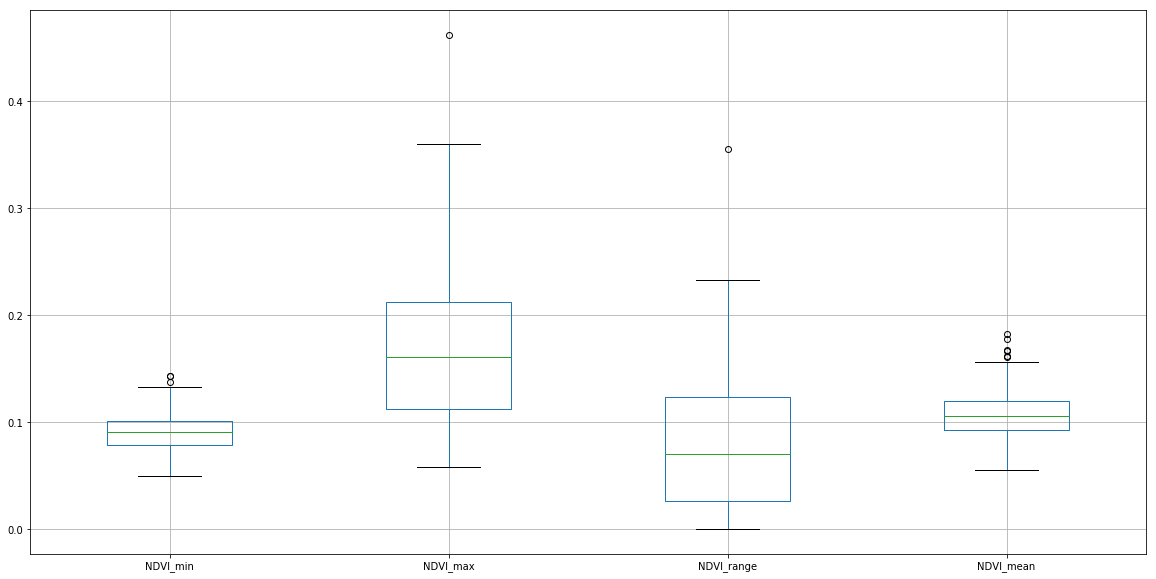

In [329]:
fig, ax = plt.subplots(figsize=(20,10))    
df[['NDVI_min','NDVI_max','NDVI_range','NDVI_mean']].boxplot(ax=ax)

In [347]:
df.loc[385,'Data Quality']#='Outlier NDVI max'

'Outlier NDVI max'

### Rangelands 

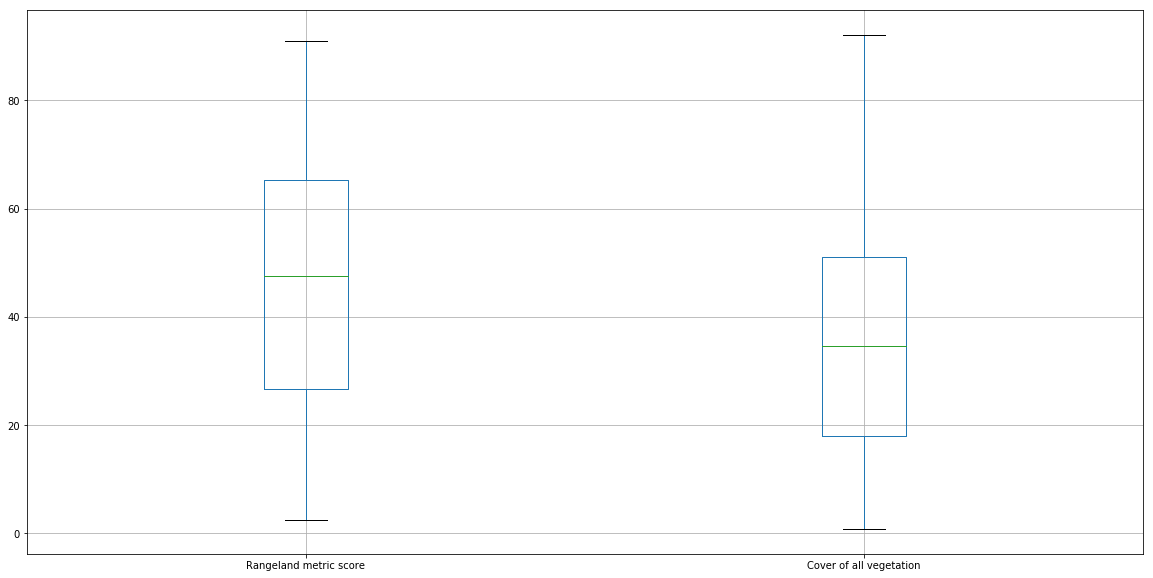

In [348]:
fig, ax = plt.subplots(figsize=(20,10))    
df[['Rangeland metric score','Cover of all vegetation']].boxplot(ax=ax)

### Categorical vars
'TNC_ecosystem_types', 
'wcs_eco', 
'EFT111-533', 
       'Kmeans_cluster_10y', 'Kmeans_cluster_g'

EFT-1
3    171
2    118
4     72
1     51
Name: EFT-1, dtype: int64
EFT-2
3    221
2    168
4     23
Name: EFT-2, dtype: int64
EFT-3
2    382
3     18
1     12
Name: EFT-3, dtype: int64


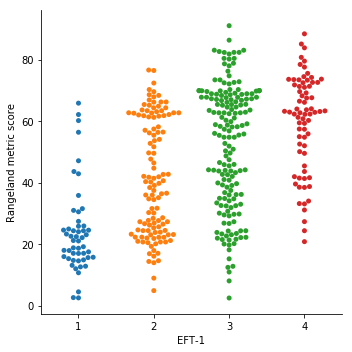

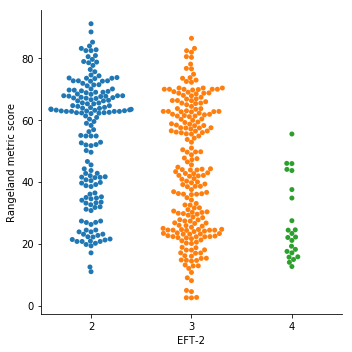

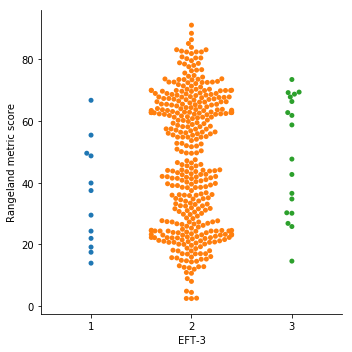

In [358]:
for col in ['EFT-1','EFT-2', 'EFT-3']:
    print(col)
    print(df[col].value_counts())
    sns.catplot(x=col, y="Rangeland metric score", kind="swarm", data=df);
    

TNC_ecosystem_types
30    150
40    141
50     33
51     22
13     19
52     15
95      8
92      7
60      6
12      6
91      2
88      2
94      1
Name: TNC_ecosystem_types, dtype: int64
wcs_eco
semi_desert      198
true_desert       93
desert_steppe     71
Name: wcs_eco, dtype: int64
Kmeans_cluster_10y
Spike/Decrease    168
Steep Increase     92
Increase           69
Noise              33
Stasis             28
Steep Decrease     22
Name: Kmeans_cluster_10y, dtype: int64
Kmeans_cluster_g
Spike     223
Up        161
Up-ish     28
Name: Kmeans_cluster_g, dtype: int64


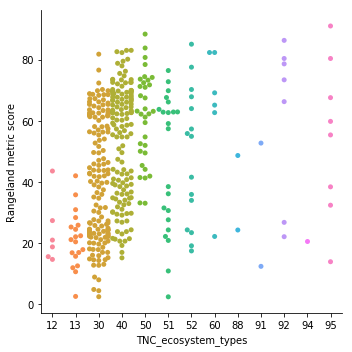

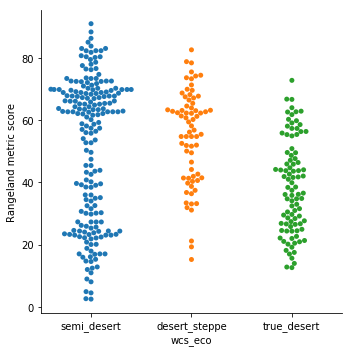

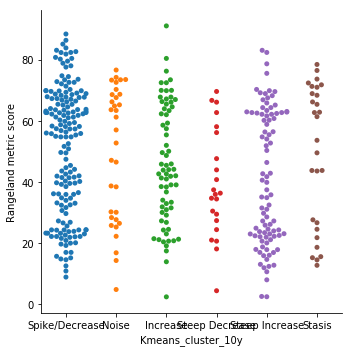

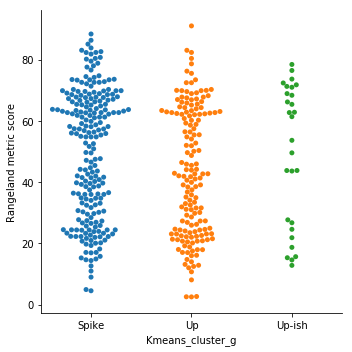

In [359]:
for col in ['TNC_ecosystem_types',
            'wcs_eco','Kmeans_cluster_10y', 'Kmeans_cluster_g']:
    print(col)
    print(df[col].value_counts())
    sns.catplot(x=col, y="Rangeland metric score", kind="swarm", data=df);
    

# Correlations between metrics

/Users/charlotteweil1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


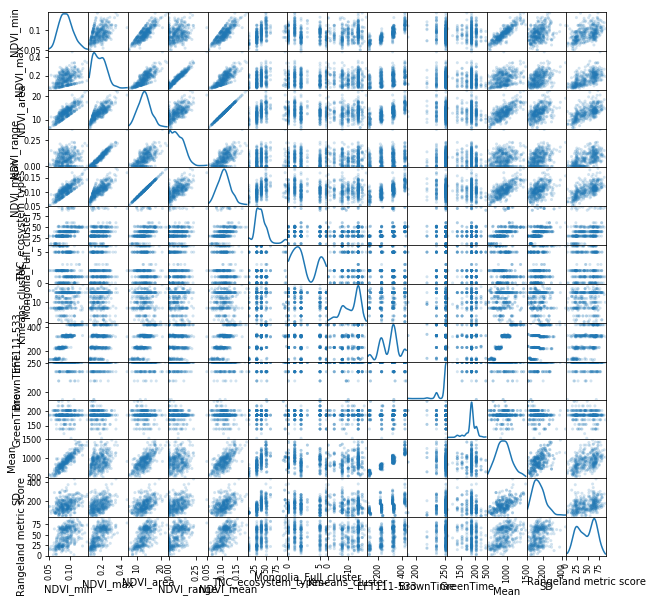

In [21]:
from pandas.plotting import scatter_matrix

fig, ax = plt.subplots(figsize=(10,10));
scatter_matrix(df[possible_predictors+['Rangeland metric score']], alpha=0.2, figsize=(6, 6), diagonal='kde',ax=ax);


/Users/charlotteweil1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


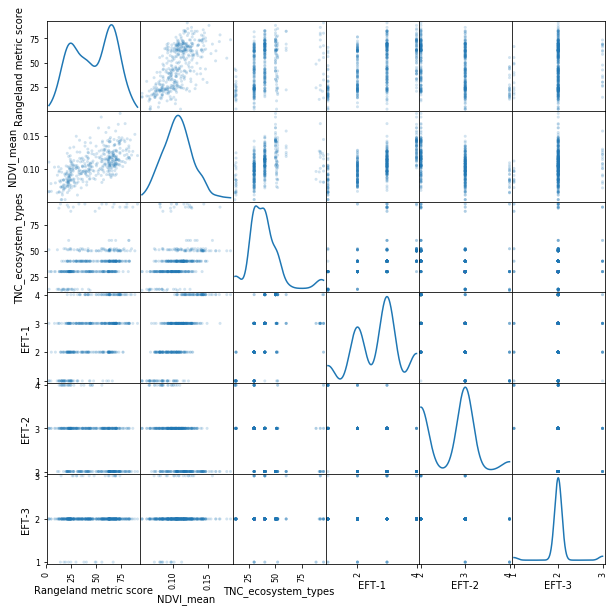

In [94]:
from pandas.plotting import scatter_matrix

fig, ax = plt.subplots(figsize=(10,10));
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde',ax=ax);


## Check that productivity clusters correlate highly with TNC ecoregions!

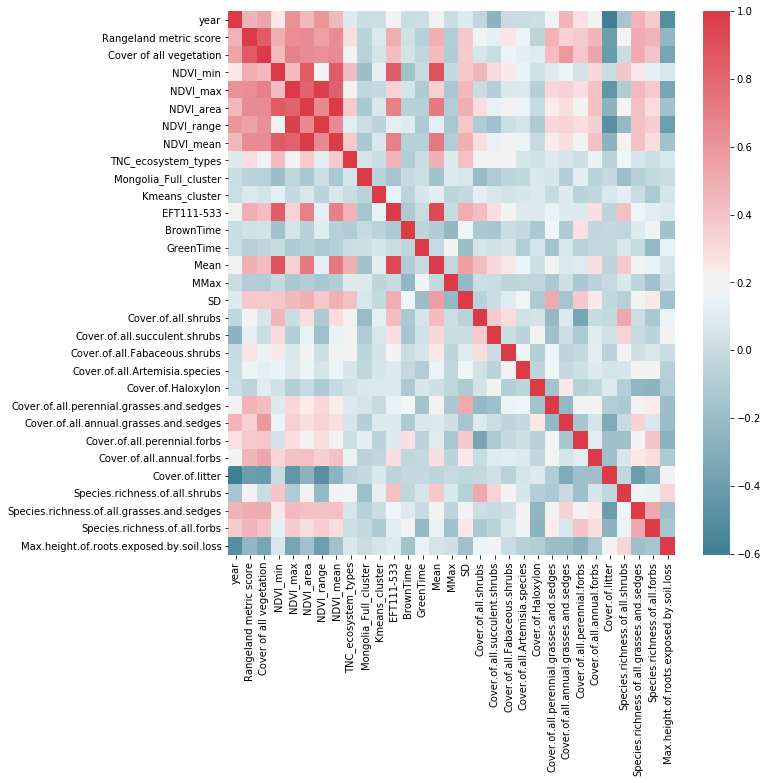

In [7]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(10,10))        
sns.heatmap(corr,
            xticklabels=corr.columns, yticklabels=corr.columns,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            ax=ax)

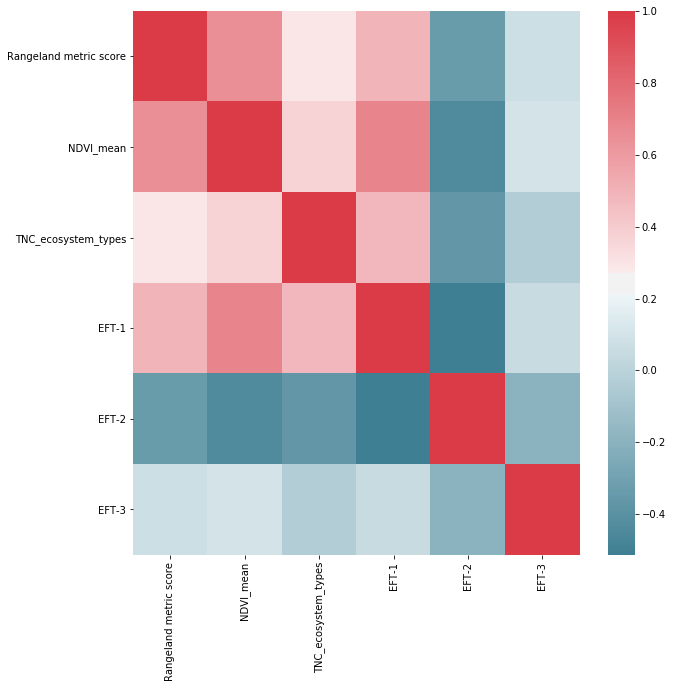

In [95]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(10,10))        
sns.heatmap(corr,
            xticklabels=corr.columns, yticklabels=corr.columns,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            ax=ax)

In [ ]:
p-values of pearson corr ?

# Simple modeling

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, metrics
import xgboost as xgb

## Split test/train

In [489]:
X = dfD.drop('Rangeland metric score',axis=1)
y = dfD['Rangeland metric score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=9)

In [454]:
len(X_train.columns)

16

## Linear modeling

Coeffs: 
 [540.2698328    1.63813235  -0.70002203   3.32038429   4.72344123
   8.78493603   2.18811744]
Mean squared error: 249.21
Coefficient of determination R2 = 0.41


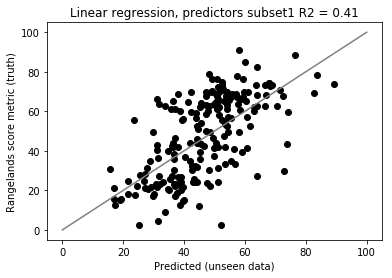

In [494]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)

y_pred = regr.predict(X_test)


##Results
# The coefficients
print('Coeffs: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test,  color='black');
plt.xlabel('Predicted (unseen data)')
plt.ylabel('Rangelands score metric (truth)')
plt.title('Linear regression, predictors subset1 R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))
plt.plot([0,100],[0,100],color='grey');


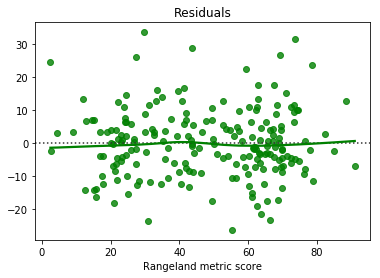

In [497]:
sns.residplot(y_test, y_pred, lowess=True, color="g");
plt.title('Residuals');


#### Some results

In [416]:
print('Coeff importance in simple linear reg\n')
for i in np.arange(0,len(X_train.columns),1):
    print(X_train.columns[i]+' : %.1f '%(abs(regr.coef_[i])/sum(abs(regr.coef_))*100)+'%')

Coeff importance in simple linear reg

NDVI_mean : 81.6 %
EFT-1 : 0.3 %
EFT-2 : 0.1 %
EFT-3 : 0.1 %
TNC_ecosyst_12 : 0.1 %
TNC_ecosyst_13 : 0.9 %
TNC_ecosyst_30 : 0.7 %
TNC_ecosyst_40 : 1.0 %
TNC_ecosyst_50 : 0.7 %
TNC_ecosyst_51 : 0.2 %
TNC_ecosyst_52 : 0.2 %
TNC_ecosyst_60 : 0.7 %
TNC_ecosyst_88 : 0.8 %
TNC_ecosyst_91 : 0.0 %
TNC_ecosyst_92 : 1.5 %
TNC_ecosyst_94 : 5.6 %
TNC_ecosyst_95 : 1.9 %
wcs_eco_desert_steppe : 1.2 %
wcs_eco_semi_desert : 1.6 %
wcs_eco_true_desert : 0.8 %


## Lasso reg & ElasticNets to make Justin proud
Estimates Lasso and Elastic-Net regression models on a manually generated sparse signal corrupted with an additive noise. Estimated coefficients are compared with the ground-truth.

Mean squared error: 280.72
Coefficient of determination R2 = 0.30


/Users/charlotteweil1/anaconda3/envs/aienv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4639.994598483827, tolerance: 14.947939892933181
  positive)


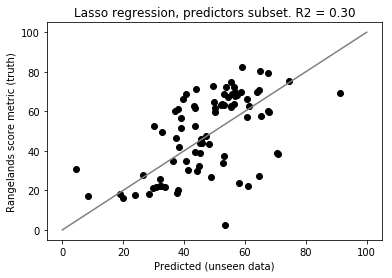

In [140]:
reg = linear_model.Lasso(alpha=0.0001)
reg.fit(X_train,y_train)

y_pred = regr.predict(X_test)


# Results
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test,  color='black');
plt.xlabel('Predicted (unseen data)')
plt.ylabel('Rangelands score metric (truth)')
plt.title('Lasso regression, predictors subset. R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))
plt.plot([0,100],[0,100],color='grey');


Mean squared error: 313.54
Coefficient of determination R2 = 0.21


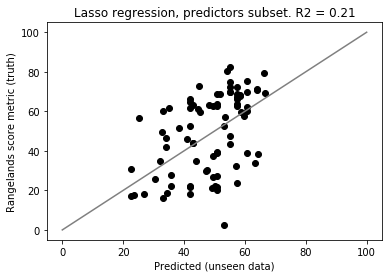

In [141]:
enet = linear_model.ElasticNet(alpha=0.09, l1_ratio=0.1)
enet.fit(X_train,y_train)

y_pred = enet.predict(X_test)


#Results
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test,  color='black');
plt.xlabel('Predicted (unseen data)')
plt.ylabel('Rangelands score metric (truth)')
plt.title('Lasso regression, predictors subset. R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))
plt.plot([0,100],[0,100],color='grey');


## Polynomial just for funzies?

## Random forest yeay

Mean squared error: 283.71
Coefficient of determination R2 = 0.33


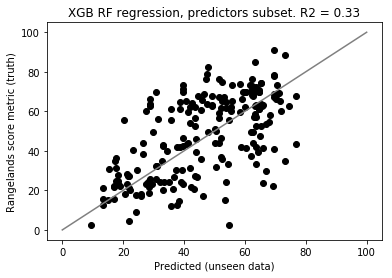

In [498]:
xgbr = xgb.XGBRegressor() 
xgbr.fit(X_train,y_train)

y_pred = xgbr.predict(X_test)




# Results
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test,  color='black');
plt.xlabel('Predicted (unseen data)')
plt.ylabel('Rangelands score metric (truth)')
plt.title('XGB RF regression, predictors subset. R2 = %.2f'
      % metrics.r2_score(y_test, y_pred))
plt.plot([0,100],[0,100],color='grey');


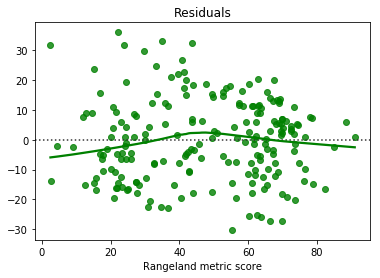

In [499]:
sns.residplot(y_test, y_pred, lowess=True, color="g");
plt.title('Residuals');

# Grid Search

In [145]:
from sklearn.model_selection import GridSearchCV

## For XGBoost and predictors subset1

https://xgboost.readthedocs.io/en/latest/parameter.html

### Tune min_child_weight and max_depth

https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'max_depth':range(3,10,2),
        }

param_test2b = {
 'min_child_weight':[6,8,10,12]
}

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

then lower learning rate


In [226]:
params = {
        'min_child_weight': [1, 5, 10],
        'max_depth':range(3,10,2),
        }

regr = GridSearchCV(xgb.XGBRegressor(), params,
                   scoring='r2',
                   verbose=True)
regr.fit(X_train,y_train)

print("Best parameters set found on train set:"+str(regr.best_params_))
std = regr.cv_results_['std_test_score'][regr.best_index_]
print("R2 = %0.3f (+/-%0.03f)"% (regr.best_score_, std * 2))


print("\nFull grid scores on train set:")
means = regr.cv_results_['mean_test_score']
stds = regr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, regr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

/Users/charlotteweil1/anaconda3/envs/aienv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters set found on train set:{'max_depth': 3, 'min_child_weight': 1}
R2 = 0.455 (+/-0.186)

Full grid scores on train set:
0.455 (+/-0.186) for {'max_depth': 3, 'min_child_weight': 1}
0.440 (+/-0.223) for {'max_depth': 3, 'min_child_weight': 5}
0.449 (+/-0.210) for {'max_depth': 3, 'min_child_weight': 10}
0.387 (+/-0.164) for {'max_depth': 5, 'min_child_weight': 1}
0.402 (+/-0.228) for {'max_depth': 5, 'min_child_weight': 5}
0.426 (+/-0.231) for {'max_depth': 5, 'min_child_weight': 10}
0.325 (+/-0.192) for {'max_depth': 7, 'min_child_weight': 1}
0.366 (+/-0.228) for {'max_depth': 7, 'min_child_weight': 5}
0.404 (+/-0.227) for {'max_depth': 7, 'min_child_weight': 10}
0.307 (+/-0.179) for {'max_depth': 9, 'min_child_weight': 1}
0.346 (+/-0.238) for {'max_depth': 9, 'min_child_weight': 5}
0.390 (+/-0.228) for {'max_depth': 9, 'min_child_weight': 10}


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.4s finished
/Users/charlotteweil1/anaconda3/envs/aienv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [232]:
params = {
        'min_child_weight': [0.01,0.1,1],
        'max_depth':range(1,4,1),
        }

regr = GridSearchCV(xgb.XGBRegressor(), params,
                   scoring='r2',cv=5)
regr.fit(X_train,y_train)

print("Best parameters set found on train set:\n"+str(regr.best_params_))
std = regr.cv_results_['std_test_score'][regr.best_index_]
print("R2 = %0.3f (+/-%0.03f)"% (regr.best_score_, std * 2))

Best parameters set found on train set:
{'max_depth': 1, 'min_child_weight': 0.01}
R2 = 0.487 (+/-0.147)


/Users/charlotteweil1/anaconda3/envs/aienv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Tune Gamma

gamma[default=0][range: (0,Inf)]


It controls regularization (or prevents overfitting). The optimal value of gamma depends on the data set and other parameter values.


Higher the value, higher the regularization. Regularization means penalizing large coefficients which don't improve the model's performance. default = 0 means no regularization.


Tune trick: Start with 0 and check CV error rate. If you see train error >>> test error, bring gamma into action. 
Higher the gamma, lower the difference in train and test CV. If you have no clue what value to use, use gamma=5 and see the performance. Remember that gamma brings improvement when you want to use shallow (low max_depth) trees.

In [234]:
## Test set error
xgbr = xgb.XGBRegressor(max_depth= 1, min_child_weight= 0.0001,gamma=0)
xgbr.fit(X_train,y_train)

y_pred = xgbr.predict(X_test[0:40])

print('Coefficient of determination R2 = %.2f'
      % metrics.r2_score(y_test[0:40], y_pred[0:40]))

Coefficient of determination R2 = 0.35


In [235]:
params = {
 'gamma':[i/10.0 for i in range(0,5)]
}

regr = GridSearchCV(xgb.XGBRegressor(max_depth= 1, min_child_weight= 0.0001),
                    params,
                    scoring='r2',cv=5)
regr.fit(X_train,y_train)

print("Best parameters set found on train set:"+str(regr.best_params_))
std = regr.cv_results_['std_test_score'][regr.best_index_]
print("R2 = %0.3f (+/-%0.03f)"% (regr.best_score_, std * 2))

Best parameters set found on train set:{'gamma': 0.0}
R2 = 0.487 (+/-0.147)


/Users/charlotteweil1/anaconda3/envs/aienv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### More tuning
(I THINK IT'S OVERFITTING) // TEST R2 IS LOW, SO LITTLE DATA. min_child_weight v. low, 'colsample_bytree' and subsample so high.

In [237]:
params = {
 'subsample':[.5,.6,.7,.8,.9,1],
 'colsample_bytree':[.5,.6,.7,.8,.9,1]
}

regr = GridSearchCV(xgb.XGBRegressor(max_depth= 1, min_child_weight= 0.0001,gamma=0),
                    params,
                    scoring='r2',cv=5)
regr.fit(X_train,y_train)

print("Best parameters set found on train set:"+str(regr.best_params_))
std = regr.cv_results_['std_test_score'][regr.best_index_]
print("R2 = %0.3f (+/-%0.03f)"% (regr.best_score_, std * 2))
    

Best parameters set found on train set:{'colsample_bytree': 0.9, 'subsample': 0.9}
R2 = 0.492 (+/-0.158)


/Users/charlotteweil1/anaconda3/envs/aienv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [238]:
params = {
 'learning_rate'=[]
}


regr = GridSearchCV(xgb.XGBRegressor(max_depth= 1, min_child_weight= 0.0001,gamma=0,
                                    subsample=.9,colsample_bytree=.9),
                    params,
                    scoring='r2',cv=5)
regr.fit(X_train,y_train)

print("Best parameters set found on train set:"+str(regr.best_params_))
std = regr.cv_results_['std_test_score'][regr.best_index_]
print("R2 = %0.3f (+/-%0.03f)"% (regr.best_score_, std * 2))
    

Best parameters set found on train set:{'colsample_bytree': 0.9, 'subsample': 0.9}
R2 = 0.492 (+/-0.158)


/Users/charlotteweil1/anaconda3/envs/aienv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [241]:
## Test set error
xgbr = xgb.XGBRegressor(max_depth= 1, min_child_weight= 0.0001,gamma=0,
                                    subsample=.9,colsample_bytree=.9)
xgbr.fit(X_train,y_train)

y_pred = xgbr.predict(X_test[0:45])

print('Coefficient of determination R2 = %.2f'
      % metrics.r2_score(y_test[0:45], y_pred[0:45]))

Coefficient of determination R2 = 0.38


# PROBLEMS?

* Dummies/categorical variables: super sparse dataset.
* Hunt outliers?

In [ ]:
xgbr = xgb.XGBRegressor(max_depth= 1, min_child_weight= 0.0001,gamma=0,
                                    subsample=.9,colsample_bytree=.9)